# Image Colorization
Custom CNN with ResNet-101  
Group 12

In [4]:
import tensorflow as tf
import numpy as np
import cv2
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from IPython.display import Image, display
import random
import h5py
import os
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Input, Concatenate, Activation, concatenate
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.utils import plot_model
from keras.initializers import RandomNormal

### Model Build


In [2]:
def generate_model(img_shape):
    # Random weight initialization 
    weight_init = RandomNormal(stddev=0.02)
    inp = Input((img_shape))

    # Download resnet net, and use it as the base.
    resnet_base = ResNet101(include_top=False, input_shape=img_shape,weights='imagenet')
    resnet = resnet_base(inp)
    
    # Encoder block
    # Input size : 224x224
    conv1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(inp)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # Input size : 112x112
    conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv1)
    conv3 =  Activation('relu')(conv3)

    # Input size : 56x56
    conv4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv3)
    conv4 = Activation('relu')(conv4)

    # Input size : 28x28
    conv5 = Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv4)
    conv5 = Activation('relu')(conv5)

    # Input size : 14x14
    conv5_ = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv5)
    conv5_ = Activation('relu')(conv5_)
    
    
    # Fusion layer - Connects Resnet with our encoder
    #Input size : 7x7
    conc = concatenate([resnet, conv5_])
    fusion = Conv2D(512, (1, 1), padding='same', kernel_initializer=weight_init)(conc)
    fusion = Activation('relu')(fusion)
    
    # Skip fusion layer
    skip_fusion = concatenate([fusion, conv5_])
    


    # Decoder block 
    # Input size : 7x7
    decoder = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_fusion)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # Skip layer from conv5 (with added dropout)
    skip_4_drop = Dropout(0.25)(conv5)
    skip_4 = concatenate([decoder, skip_4_drop])
    
    # Input size : 14x14
    decoder = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_4)
    decoder = Activation('relu')(decoder)

    # Skip layer from conv4_ (with added dropout)
    skip_3_drop = Dropout(0.25)(conv4)
    skip_3 = concatenate([decoder, skip_3_drop])
    
    # Input size : 28x28
    decoder = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_3)
    decoder = Activation('relu')(decoder)
    
    # Input size : 56x56
    decoder = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)

    # Input size : 112x112
    decoder = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)

    # Input size : 112x112
    decoder = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)
    
    # Output layer, with 2 channels (a and b) --> Input size : 224x224
    output_layer = Conv2D(2, (1, 1), activation='tanh')(decoder)

    # In regards to the loss function, this model uses MSE with a tanh activation as CrossEntropy didn't result in much improvement of the results
    model = Model(inp, output_layer)
    model.compile(Adam(learning_rate=0.0002), loss='mse', metrics=['accuracy'])
    
    return model

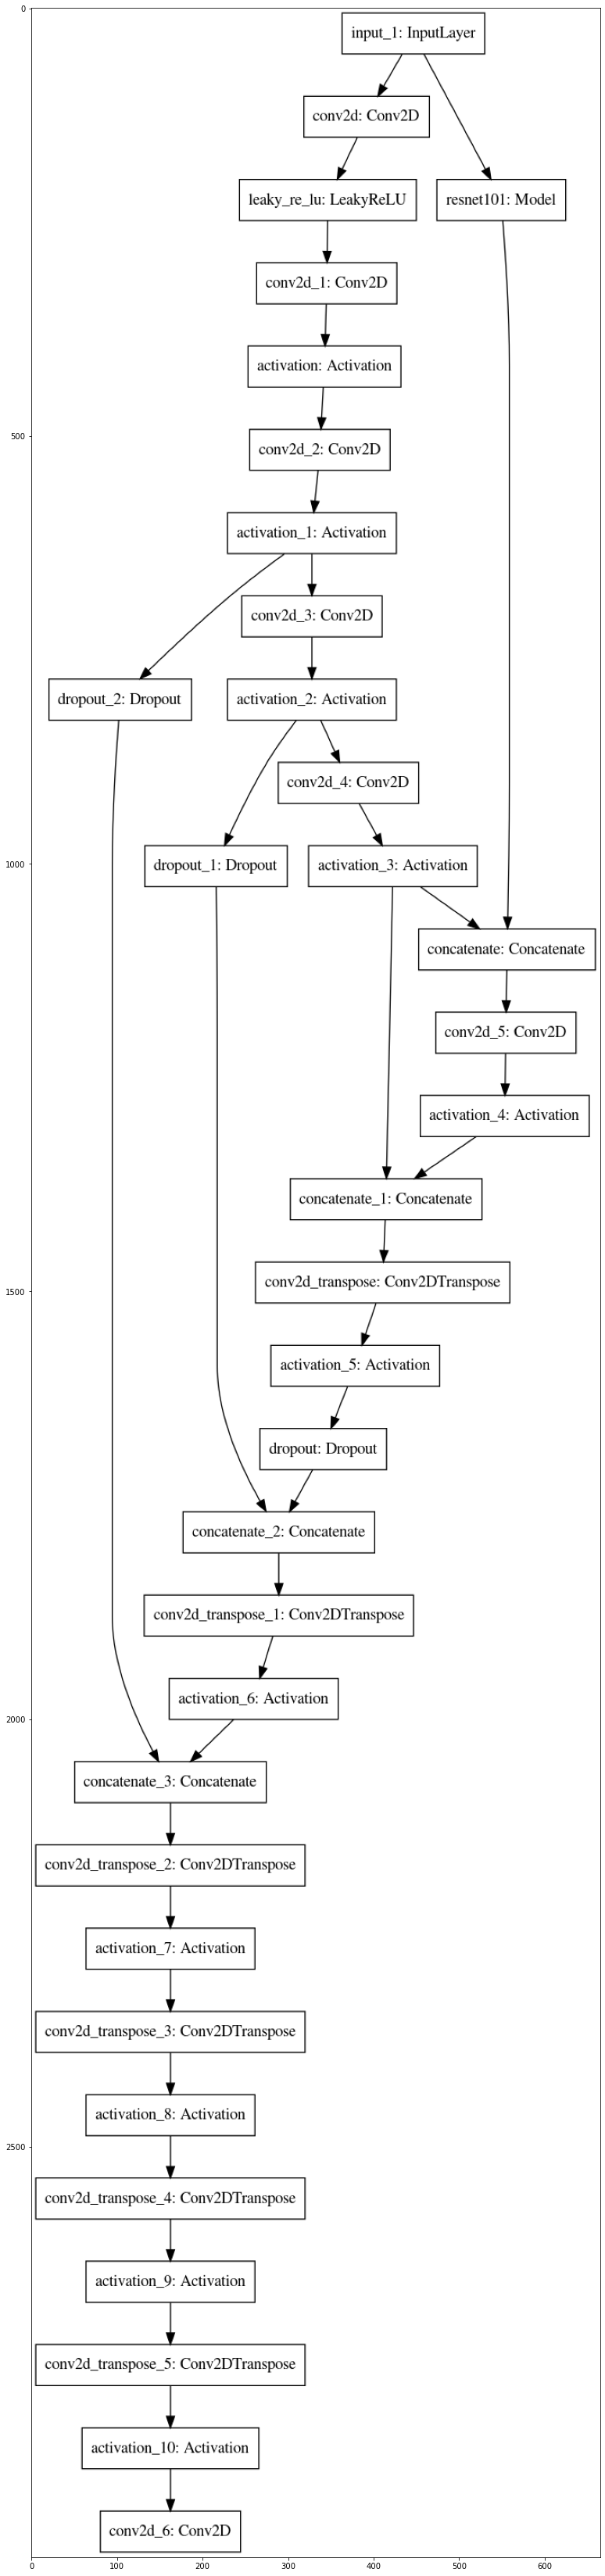

In [3]:
# Show final architecture diagram
model = generate_model((224, 224, 3))
plot_model(model, 'model_diagram.png')
plt.figure(figsize=(160, 60))
plt.imshow(Image.open('model_diagram.png'))

### Functions
Training, prediction, graphing, image type conversion, input and output image results

In [4]:
# Function to perform training 
def train(model, gray, ab, epochs, batch_size):
    # Convert the input image from (224, 224, 1) to (224, 224, 3) by copying the value to match resnet's requirements
    l = np.repeat(gray[..., np.newaxis], 3, -1)
    
    # Normalize the data
    l = (l.astype('float32') - 127.5) / 127.5
    ab = (ab.astype('float32') - 127.5) / 127.5

    history = model.fit(l,ab,epochs=epochs,validation_split=0.05,batch_size=batch_size)
    return history

In [5]:
# Get prediction from the model based of the 'L' grayscale image
def get_pred(model, img_l):
    # Repeat the L value 3 times to match input shape of 3 channels
    inp = np.repeat(img_l[..., np.newaxis], 3, -1)
    inp = inp.reshape((1, 224, 224, 3))
    # Normalize input image's values and predict colorized image using model
    inp = (inp.astype('float32') - 127.5) / 127.5
    prediction = model.predict(inp)
    # Normalize the output
    pred = (prediction[0].astype('float32') * 127.5) + 127.5
    return pred

In [6]:
# Generate graphs for training and validation
def generate_graphs(epochs, train_data, val_data, y_label, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=train_data,marker=dict(color="mediumpurple"), name="Training"))
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=val_data,marker=dict(color="forestgreen"), name="Validation"))
    fig.update_layout(title_text=title, yaxis_title=y_label,xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [7]:
# LAB image contains 3 parts - L, A, and B - and the input image contains only the L part. To display the color image, concatenate the L and AB parts.
# Convert to RGB for display.
def lab_img(img_l, img_ab):
    img_l = img_l.reshape((224, 224, 1))
    img_lab = np.concatenate((img_l, img_ab), axis=2)
    img_lab = img_lab.astype("uint8")
    img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    img = Image.fromarray(img)
    return img

In [8]:
# Create sample images for display
def get_results(model, gray_imgs, n):
    images = []
    for i in range(n):
        # Select random images
        r = random.randint(0, gray_imgs.shape[0])

        # Get the model's prediction of ab part, then get final output image.
        pred = get_pred(model, gray_imgs[r])
        img = lab_img(gray_imgs[r], pred)
        
        # Create new combined image and save it
        fin = Image.new('RGB', (448, 224))
        gray_image = Image.fromarray(gray_imgs[r])
        fin.paste(gray_image, (0,0))
        fin.paste(img, (224, 0))

        # Save the image with a unique name with index
        i = len(os.listdir("/kaggle/working/"))
        fin.save("/kaggle/working/" + str(i)+('_%i.png' % r))
        images.append(fin)
    return images

### Training the model

In [9]:

# Read the dataset
images_l = np.load("../input/image-colorization/l/gray_scale.npy")
images_ab = np.load("../input/image-colorization/ab/ab/ab1.npy")

# Define batch size and epochs 
batch_size = 32
epochs = 30

# Create model
model = generate_model((224, 224, 3))

# Train the model and keep history for graphing
history = train(model, images_l[:3500], images_ab[:3500], epochs, batch_size)

Train on 3325 samples, validate on 175 samples
Epoch 1/30
3325/3325 [==============================] - 66s 20ms/sample - loss: 0.0167 - accuracy: 0.5155 - val_loss: 0.0178 - val_accuracy: 0.5312
Epoch 2/30
3325/3325 [==============================] - 45s 14ms/sample - loss: 0.0159 - accuracy: 0.5464 - val_loss: 0.0246 - val_accuracy: 0.5326
Epoch 3/30
3325/3325 [==============================] - 45s 14ms/sample - loss: 0.0155 - accuracy: 0.5915 - val_loss: 0.0177 - val_accuracy: 0.5671
Epoch 4/30
3325/3325 [==============================] - 45s 14ms/sample - loss: 0.0146 - accuracy: 0.6181 - val_loss: 0.0176 - val_accuracy: 0.5588
Epoch 5/30
3325/3325 [==============================] - 45s 14ms/sample - loss: 0.0136 - accuracy: 0.6332 - val_loss: 0.0173 - val_accuracy: 0.5415
Epoch 6/30
3325/3325 [==============================] - 45s 14ms/sample - loss: 0.0125 - accuracy: 0.6491 - val_loss: 0.0188 - val_accuracy: 0.5563
Epoch 7/30
3325/3325 [==============================] - 45s 14ms/

In [10]:
# Graphing of loss and accuracy while training - shows increasing accuracy and decreasing loss
generate_graphs(epochs, history.history['loss'], history.history['val_loss'], 'Loss', "Loss while training")
generate_graphs(epochs, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', "Accuracy while training")

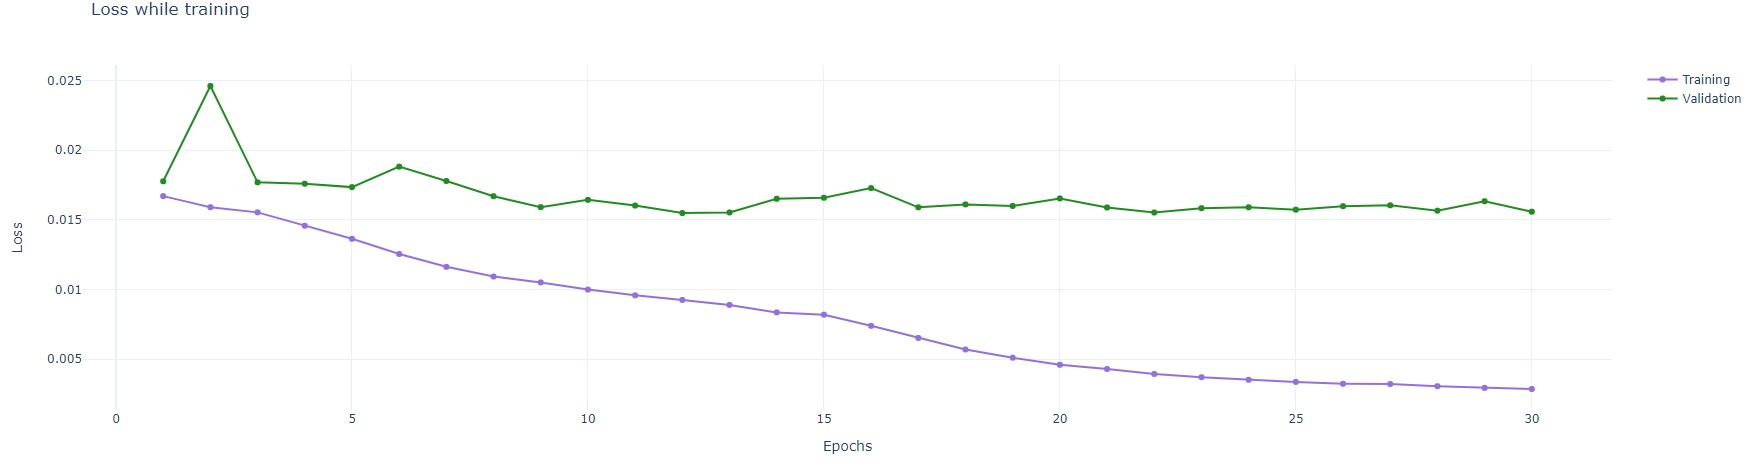

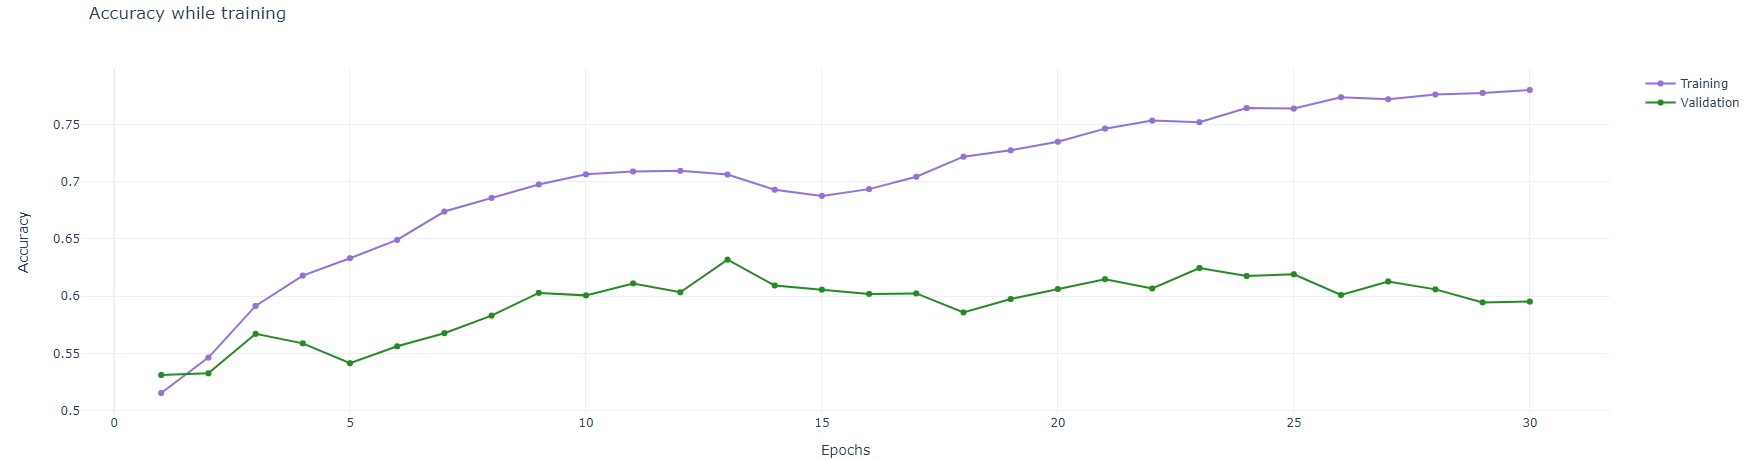

In [14]:
images = ['resnet_loss.jpg','resnet_accuracy.jpg']
for i in images:
    display(Image(filename=i))

### Visualizing data and predictions

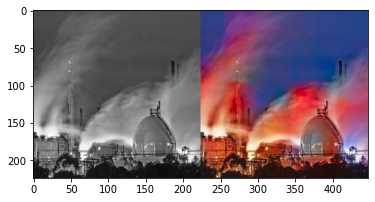

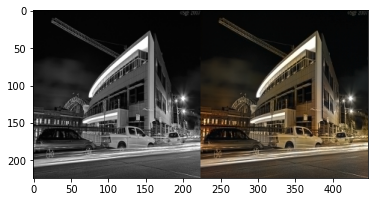

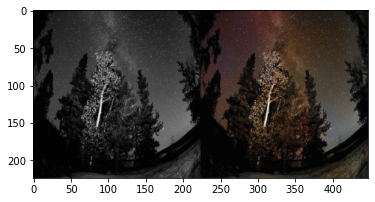

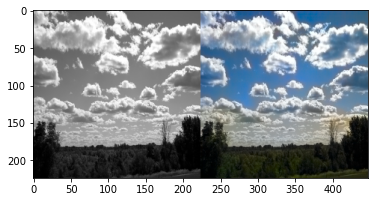

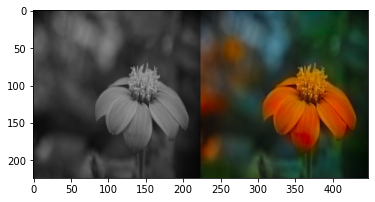

In [11]:
# Get 5 sample images and display
data = get_results(model, images_l, 5)
for i in data:
    plt.figure()
    plt.imshow(np.array(i))